In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random
import struct
%matplotlib inline

## 预处理数据
### 以二进制文件形式读入

In [2]:
with open('train-images.idx3-ubyte','rb') as f:
    trainImage = f.read()
with open('train-labels.idx1-ubyte','rb') as f:
    trainLabel = f.read()
with open('t10k-images.idx3-ubyte','rb') as f:
    testImage = f.read()
with open('t10k-labels.idx1-ubyte','rb') as f:
    testLabel = f.read()

### 提取图片和标签
得到numpy.ndarray表示的数据, shape如下

```python
trainImage.shape = (60000,28,28)
trainLabel.shape = (60000,1)
testImage.shape = (10000, 28, 28)
testLabel.shape = (10000, 1)
```

In [3]:
# API : struct.unpack(fmt,bytes)

# bytes -> (int,int,int,int,numpy.ndarray[])
# 接受dataSet原始二进制数据, 返回array, shape为(60000,28,28)
def getImageFromMNIST(imageBytes):
    assert(type(imageBytes) is bytes),'parameter is no bytes'
    magicNum, numOfImages = struct.unpack('>2i',imageBytes[:8]) # 读入校验数据(无用处)和图片数量
    rows, columns = struct.unpack('>2i',imageBytes[8:16]) # 读入图片行数和列数
    imageSize = rows * columns # 行 * 列 = 图片的规模
    # 读入所有图片数据, 总共有 图片规模 * 图片数量 个 unsigned byte
    imageTuple = struct.unpack('>'+str(imageSize * numOfImages)+'B',imageBytes[16:])
    imageArray = np.array(imageTuple) # 数据类型为默认的int
    return imageArray.reshape(numOfImages,rows,columns)

def getLabelFromMNIST(labelBytes):
    assert(type(labelBytes) is bytes),'parameter is no bytes'
    magicNum, numOfLabels = struct.unpack('>2i',labelBytes[:8]) # 读入校验数据(无用处)和标签数量
    # 每个标签大小为unsigned byte, 一次读入所有标签
    labelSize = 1 * numOfLabels
    labelTuple = struct.unpack('>'+str(labelSize)+'B',labelBytes[8:])
    labelArray = np.array(labelTuple) 
    return labelArray.reshape(labelSize,1)

trainImage = getImageFromMNIST(trainImage)
trainLabel = getLabelFromMNIST(trainLabel)
testImage = getImageFromMNIST(testImage)
testLabel = getLabelFromMNIST(testLabel)

print('trainImage.shape:',trainImage.shape)
print('trainLabel.shape:',trainLabel.shape)
print('testImage.shape:',testImage.shape)
print('testLabel.shape:',testLabel.shape)

trainImage.shape: (60000, 28, 28)
trainLabel.shape: (60000, 1)
testImage.shape: (10000, 28, 28)
testLabel.shape: (10000, 1)


### 数据显示测试

Text(0.5,1,'[5]')

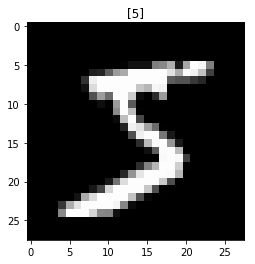

In [4]:
# index = 0 # 第 几 张图片
# im = Image.fromarray(trainImage[index,:]) # array -> Image, 如果数据类型为float, 会报错
# plt.imshow(im) # 显示图片
# plt.title(str(trainLabel[index])) # 打上标题

### 归一化 和 创建 标签矩阵
$28 \times 28 = 784$

处理后,
```python
trainImage.shape = (784, 60000) # (60000, 28, 28) -> (784, 60000)
trainLabel.shape = (10, 60000)  # (60000,1) -> (10, 60000)
testImage.shape = (784, 10000)  # (10000, 28, 28) -> (784, 10000)
testLabel.shape = (10, 10000)   # (10000, 1) -> (10, 10000)
```

数据含义
```python
trainImage[:,i]会得到shape = (784,) 的一列数据, 代表一张图片
testLabel[:,i]会得到shape = (10,) 的一列数据, 代表一个标签
```

In [5]:
# (number, 28, 28) -> (784, number)
def changeImage(image):
    image = image.reshape(-1,28*28)
    image = image.T # 转置, 让图片数据变为列表示
    image = image.astype(np.float16) # 重置数据类型为numpy.float16
    return image / 255.0 # 归一化, 让值落在[0,1]上, 方便训练

# (number, 1) -> (10, number)
def changeLabel(label):
    assert(label.shape[1] == 1)
    column = np.arange(10) # get 0~9, shape = (10,)
    column = column.reshape(10,1) # to column
    return label.T == column # use broadcasting to generate True or False label
    
trainImage = changeImage(trainImage)
trainLabel = changeLabel(trainLabel)
testImage = changeImage(testImage)
testLabel = changeLabel(testLabel)

print('trainImage.shape:',trainImage.shape)
print('trainLabel.shape:',trainLabel.shape)
print('testImage.shape:',testImage.shape)
print('testLabel.shape:',testLabel.shape)

trainImage.shape: (784, 60000)
trainLabel.shape: (10, 60000)
testImage.shape: (784, 10000)
testLabel.shape: (10, 10000)


### 测试归一化是否正确


[False False False False False  True False False False False]


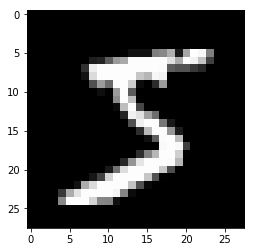

In [14]:
# oneImage = trainImage[:,0]
# oneImage = (oneImage * 255).astype(int).reshape(28,28)
# oneImage = Image.fromarray(oneImage)
# plt.imshow(oneImage)
# print(trainLabel[:,0])

## 开始处理
### 载入神经网络
#### import

In [15]:
import os
import importlib
# 如果模块NN在路径youryourModulePath
os.sys.path.append('C:\\Users\\lambda\\Desktop\\temp\\python\\deepLearning') # 参数为字符串str
import NN

my Neural Network import succeed


#### 初始化网络

$$
Lost = - \sum _{i=0} ^{9} y_i \ln a_i
$$

In [177]:
%%time
np.random.seed(1) # 改变随机数种子, 方便复现bug
data = {
'trainX':trainImage,
'trainY':trainLabel
}

layers = [784,128,128,128,128,10] # 784代表输入数据规模, layers[i] 代表第 i 层网络的节点数
print('layers info:',layers)

relu = lambda z:np.maximum(0,z) # Relu 激活函数
relu_deriv = lambda z,a:np.where(z > 0,1.0,0.01) # Relu 激活函数的导数

def lostFunc(A,Y):
    assert(A.shape == Y.shape),'A.shape != Y.shape'
    # A and Y are matrix, but we just want to operation on column, so use axis = 0
    ylna = np.multiply(Y,np.log(A+1e-10)) # add 1e-10 to forbidden np.log(0)
    return -np.sum(ylna,axis = 0,keepdims=True) # remember add minus symbol "-"
    
def softmax(Z): # Z is a column vector, but we need to handle when Z is a matrix, use axis = 0
    maxNumber = np.max(Z,axis = 0,keepdims=True)
    assert(Z.shape[1] == maxNumber.shape[1])
    Z -= maxNumber
    Zexp = np.exp(Z)
    return Zexp / np.sum(Zexp,axis = 0,keepdims=True)

def softmax_deriv(Z,A,Y): # softmax 的导数
    assert(A.shape == Y.shape),'A.shape is not same as Y.shape'
    return A - Y



def getFunction(layers): # 初始化function
    function = {
                'activation':{},
                'derivative':{},
                'lostFunction':lostFunc, # lambda a,y:np.sum(np.multiply(-y,np.log(a)),axis = 0), # (AL,Y) -> Lost(AL,Y)
                'predictFunction':lambda A:(A,A>=np.max(A,axis = 0)), # (A,preA)
                'accuracyFunction':lambda A,Y:1.0/Y.shape[1] * np.sum((np.sum(A==Y,axis = 0,keepdims=True) == 10))
                }
    L = len(layers) - 1
    for i in range(1,L):
        function['activation'][i] = relu
        function['derivative'][i] = relu_deriv
    function['activation'][L] = softmax
    function['derivative'][L] = lambda Z,A,Y:softmax_deriv(Z,A,Y)
    return function

function = getFunction(layers)
importlib.reload(NN) # 重新import模块, 便于修改后重新import
myNN = NN.NN(data,layers,function) # 初始化网络!!!!!!

layers info: [784, 128, 128, 128, 128, 10]
my Neural Network import succeed
Wall time: 0 ns


#### 开始训练

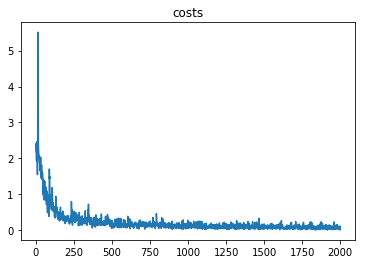

train accuracy: 0.976416666667
test 1~10000 accuracy: 0.9663
test 1~5000 accuracy: 0.9534
test 5000~10000 accuracy: 0.9792
Wall time: 17.4 s


In [178]:
%%time
costs = myNN.miniBatchRandom(learningRate=0.5,batchSize=128,batchTimes=2000,getCost=True)
plt.plot(costs)
plt.title('costs')
plt.show()
trainPre,trainPreBool = myNN.predict(X=trainImage)
print('train accuracy:',myNN.accuracy(trainPreBool,trainLabel))

testPre,testPreBool = myNN.predict(X=testImage)
print('test 1~10000 accuracy:',myNN.accuracy(testPreBool,testLabel))

testPre,testPreBool = myNN.predict(X=testImage[:,:5000])
print('test 1~5000 accuracy:',myNN.accuracy(testPreBool,testLabel[:,:5000])) # 前5000个样本的正确率

testPre,testPreBool = myNN.predict(X=testImage[:,5000:])
print('test 5000~10000 accuracy:',myNN.accuracy(testPreBool,testLabel[:,5000:])) # 后5000个样本的正确率

## 测试自己的图片

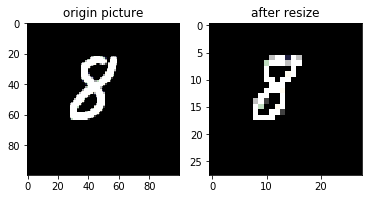

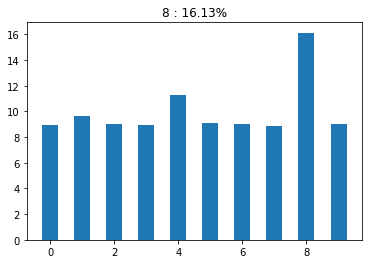

In [183]:
myNumber = Image.open('number.bmp') # 打开图片,注意图片本身的格式, 如果是256色模式, 就不用将RGB相加了

plt.subplot(121)
plt.imshow(myNumber) # 显示图片
plt.title('origin picture')
myNumber = myNumber.resize(size=(28,28)) # 重置大小, 宽度为28, 高度为28

plt.subplot(122)
plt.imshow(myNumber) # 显示resize后的图片
plt.title('after resize')
plt.show()


myNumberArr = np.array(myNumber) # 从图片获取 array
# print(myNumberArr.shape)

# 归一化后才可以predict
myNumberArr = (myNumberArr > 100).astype(float)
myNumberArr = myNumberArr.reshape(28*28,1)
myPre,myPreBool = myNN.predict(X=myNumberArr)

# print(myPreBool.T)
# plt.figure()
probablity = (softmax(myPre).T.reshape(10,) * 100).tolist()
# print(probablity)
preNumber = probablity.index(max(probablity))
plt.title(str(preNumber)+' : '+str(round(max(probablity),2))+'%')
plt.bar([i for i in range(10)],probablity,[0.5 for i in range(10)], \
        align = 'center')
plt.show()